In [1]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup


load_verbose = 0
loaded_labels = []
loaded_text = []
labels = {"Barack Obama": 0,
          "Donald J. Trump": 1,
          "Dwight D. Eisenhower": 2,
          "Franklin D. Roosevelt": 3,
          "George Bush": 4,
          "George W. Bush": 5,
          "Gerald R. Ford": 6,
          "Harry S. Truman": 7,
          "Herbert Hoover": 8,
          "Jimmy Carter": 9,
          "John F. Kennedy": 10,
          "Lyndon B. Johnson": 11,
          "Richard Nixon": 12,
          "Ronald Reagan": 13,
          "William J. Clinton": 14}

# load raw text files straight in, no parsing
file_to_label = {"Obama": "Barack Obama", 
                     "Trump": "Donald J. Trump",
                     "Eisenhower": "Dwight D. Eisenhower",
                     "Roosevelt": "Franklin D. Roosevelt",
                     "Bush": "George Bush",
                     "WBush": "George W. Bush",
                     "Ford": "Gerald R. Ford",
                     "Truman": "Harry S. Truman",
                     "Hoover": "Herbert Hoover",
                     "Carter": "Jimmy Carter",
                     "Kennedy": "John F. Kennedy",
                     "Johnson": "Lyndon B. Johnson",
                     "Nixon": "Richard Nixon",
                     "Reagan": "Ronald Reagan",
                     "Clinton": "William J. Clinton"
                    }

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
        arr = filename.replace(directory,'').split("_")
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
        arr = filename.replace(directory,'').split("_")
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 25 speeches for 2 presidents.
Loaded 1742 speeches for 15 presidents.


In [2]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_\n"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    #"Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '', loaded_text[x])
    #"...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]', '7', loaded_text[x])
    #"...any character with a frequency lower than 1 in 10,000 is discarded." (+ \n)
    loaded_text[x] = loaded_text[x].translate(trantab)
    #"Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

In [3]:
#
# Summary stats
#
max_speech_len_char = (len(max(loaded_text, key=len)))
average_speech_len_char = sum( map(len, loaded_text) ) / len(loaded_text)
min_speech_len_char = min( map(len, loaded_text) ) 

print "Maximum speech length in characters:", max_speech_len_char
print "Average speech length in characters:",  average_speech_len_char
print "Minimum speech length in characters:",  min_speech_len_char

Maximum speech length in characters: 70179
Average speech length in characters: 15331
Minimum speech length in characters: 99


In [4]:
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(loaded_text)
tokenized_text = tokenizer.texts_to_sequences(loaded_text)

print len(tokenizer.word_counts)
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

//anaconda/envs/keras_tf/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


67
[(4779860, ' '), (2612968, 'e'), (2163313, 't'), (1650322, 'o'), (1630891, 'a'), (1504012, 'n'), (1426968, 'i'), (1212126, 's'), (1176131, 'r'), (1081677, 'h'), (761869, 'l'), (717147, 'd'), (557149, 'u'), (543034, 'c'), (484635, 'm'), (422412, 'w'), (396979, 'g'), (396693, 'f'), (385912, 'p'), (380068, 'y'), (284068, 'b'), (273698, '.'), (268637, ','), (242741, 'v'), (180283, 'I'), (152154, 'k'), (97593, "'"), (96524, '7'), (75237, 'A'), (68453, 'T'), (63465, 'S'), (45527, '-'), (42264, 'W'), (39078, 'N'), (36686, 'C'), (36413, 'E'), (34117, 'x'), (32963, 'P'), (29536, 'M'), (26207, 'B'), (25516, 'j'), (25008, 'R'), (23022, 'H'), (21999, 'q'), (20624, 'D'), (20284, 'O'), (19919, 'G'), (16330, 'U'), (14328, 'F'), (12993, 'L'), (12287, ':'), (12082, 'z'), (10928, '"'), (10783, 'Y'), (10572, '?'), (9734, ';'), (8803, 'J'), (5285, 'V'), (4626, 'K'), (4623, 'Q'), (4063, '$'), (1855, '/'), (585, '\\'), (455, 'Z'), (418, 'X'), (1, '}'), (1, '+')]


In [37]:
def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 200

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = loaded_labels[idx]
    current_speech = tokenized_text[idx]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print len( split_text )
print len( split_labels )

132669
132669


In [39]:
import numpy as np
from keras.utils import to_categorical

# note that max sentence length here is char NOT word
max_chars = len(tokenizer.word_counts)

X = np.array(split_text)
print np.unique(X)
print len(np.unique(X)) == max_chars
print X.shape

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False,n_values=max_chars+1,dtype=np.int)
X = enc.fit_transform(X)
print type(X), X.shape
X = np.ndarray.reshape(X,(max_chars+1,max_seq_len,-1)).T
print type(X), X.shape

# one-hot encode classes
y = to_categorical(split_labels)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=45)

print "Prepared training (", train_X.shape, "records) and test (", test_X.shape, "records) data sets."
print train_X.shape, train_y.shape

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
True
(132669, 200)
<type 'numpy.ndarray'> (132669, 13600)
<type 'numpy.ndarray'> (132669, 200, 68)
Prepared training ( (106135, 200, 68) records) and test ( (26534, 200, 68) records) data sets.
(106135, 200, 68) (106135, 15)


In [40]:
#custom activation described in Bagnall 2015
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less_equal(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout, LSTM
from keras.optimizers import adagrad, adam, adamax, rmsprop

batch_size = 100
epochs = 20

model = Sequential()
model.add(SimpleRNN(200, activation="relu", input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.2)) 
model.add(Dense(15, activation='softmax'))

# The network is trained using a variant of adagrad...
optimizer = adagrad(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=batch_size, epochs=epochs, verbose=1)

# Loss function: 
# Drop-out: 0
# Learning rate: < 0.01
# Optimizers: x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 200)               53800     
_________________________________________________________________
dense_7 (Dense)              (None, 15)                3015      
Total params: 56,815
Trainable params: 56,815
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
106135/106135 [==============================] - 218s - loss: 2.6618 - categorical_accuracy: 0.1400   
Epoch 2/20
106135/106135 [==============================] - 204s - loss: 2.5759 - categorical_accuracy: 0.1824   
Epoch 3/20
106135/106135 [==============================] - 204s - loss: 2.5602 - categorical_accuracy: 0.1827   
Epoch 4/20
106135/106135 [==============================] - 202s - loss: 2.5578 - categorical_accuracy: 0.1827   
Epoch 5/20
 49700/106135 [=============>................] - ETA: 116s - l

KeyboardInterrupt: 

In [42]:
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
26528/26534 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[2.558396211194859, 0.18463103942224324]

Predicting using test data...
26500/26534 [============================>.] - ETA: 0sDone prediction.


Confusion matrix, without normalization
[[4862    0   51    1    0    0    0    0    0    0    0    1    0    0
     0]
 [ 432    0    6    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2979    0   37    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2036    0   21    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1867    0   28    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1723    0   15    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 724    0    6    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1985    0   24    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 915    0    6    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1324    0   14    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1333    0   16    0    1    0    0    0    0    0    0    0    0    0
     0]
 [2363    0   26    0    0    0    0    0    0    0    0    0    0    0
     0]


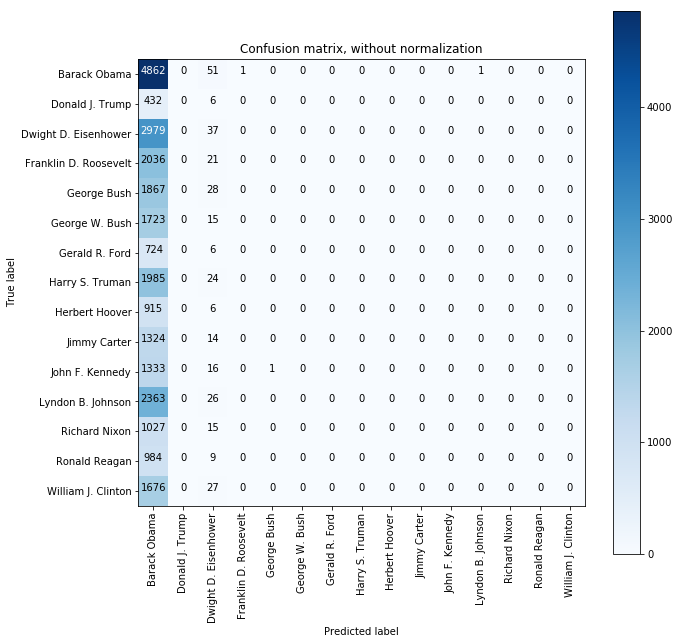

In [43]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()